### 一、分析背景
近年来房地产行业发展迅猛，二手房的买卖也成为一种新的热门。为了分析厦门地区二手房交易情况，本次项目分析了行业巨头链家关于厦门市二手房的交易数据。

### 二、提出问题
1. 二手房交易数量随时间的变化情况
2. 交易数量与月份的关系，哪个月份房子销售数量最高
3. 最受欢迎的户型是哪一种户型
4. 单位面积价格是否受到产权属性的影响
5. 每个区域单位面积价格的高低、排名情况


### 三、数据概况
数据来源于域名为'lianjia.com'的链家网，数据包含厦门市2015年5月到2020年4月的二手房房交易信息，共8325条数据，
每条数据包含如下字段：

<br>name-链家网标题 
<br>total_price-交易总价
<br>unit_price-单价
<br>time-交易时间
<br>area-房屋面积
<br>type-户型
<br>direction-朝向
<br>fitment-装修情况
<br>location-地理位置
<br>residential-所属小区
<br>elevator-是否有电梯
<br>purpose-房屋用途
<br>property-房屋产权属性
<br>property_year-产权年限
<br>year-房屋建成年代

### 四、数据清洗

In [1]:
import pymongo
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [3]:
client = pymongo.MongoClient(host='localhost', port=27017)
db = client['lianjia']
cursor = db['deal_2020_4_11'].find()
df = pd.DataFrame(list(cursor))
df.head(1)

,_id,area,direction,elevator,fitment,location,name,property,property_year,purpose,residential,time,total_price,type,unit_price,year
0,5e9193f5df50f1be5d63c335,79.23㎡,南 北,有,精装,翔安 马巷,海翼0592 2室2厅 79.23平米,商品房,70年,普通住宅,海翼0592,2020.03.24,166,2室2厅1厨1卫,20952,未知


In [4]:
# id列为无用信息，取不包含id列的子集
df_deal = df.iloc[:,1:].copy()

In [5]:
# 将所有列中数据前后空格去除
for col in df_deal.columns:
    df_deal[col] = df_deal[col].apply(lambda x : x.strip())

In [6]:
df_deal['purpose'].unique()

array(['普通住宅', '商业办公类', '车库', '别墅', '平房'], dtype=object)

In [7]:
# 将purpose为‘车库’的行去除
df_deal = df_deal[~df_deal['purpose'].str.contains('车库')]
df_deal['purpose'].unique()

array(['普通住宅', '商业办公类', '别墅', '平房'], dtype=object)

In [8]:
# 将‘面积’、‘房子总价’、‘单价’列加上单位
df_deal.rename(columns={'area':'area/㎡','total_price':'total_price/ten_thousand','unit_price':'unit_price/yuan'},inplace=True)
df_deal.columns

Index(['area/㎡', 'direction', 'elevator', 'fitment', 'location', 'name',
       'property', 'property_year', 'purpose', 'residential', 'time',
       'total_price/ten_thousand', 'type', 'unit_price/yuan', 'year'],
      dtype='object')

In [9]:
# 将‘面积’，‘产权年限’列中的各数据项单位去除
df_deal['area/㎡'] = df_deal['area/㎡'].str.extract('(\d+)',expand=True)
df_deal['property_year'] = df_deal['property_year'].str.extract('(\d+)',expand=True)
df_deal.head(2)

,area/㎡,direction,elevator,fitment,location,name,property,property_year,purpose,residential,time,total_price/ten_thousand,type,unit_price/yuan,year
0,79,南 北,有,精装,翔安 马巷,海翼0592 2室2厅 79.23平米,商品房,70,普通住宅,海翼0592,2020.03.24,166,2室2厅1厨1卫,20952,未知
1,95,南 北,有,毛坯,翔安 翔安新城,阳光城翡丽湾二期 3室1厅 95平米,商品房,70,普通住宅,阳光城翡丽湾二期,2020.03.23,251,3室1厅1厨1卫,26422,2015


In [10]:
# 将‘总价’、‘单价’列数据类型由object转换为int，将‘面积’列的数据类型由object转化为float。
df_deal['area/㎡'] = df_deal['area/㎡'].astype('float64')
df_deal['total_price/ten_thousand'] = df_deal['total_price/ten_thousand'].astype('int64')
df_deal['unit_price/yuan'] = df_deal['unit_price/yuan'].astype('int64')

In [11]:
#将列交易时间的数据类型由object更改为datetime
df_deal['time'] = pd.to_datetime(df_deal['time'])
df_deal.dtypes

area/㎡                             float64
direction                           object
elevator                            object
fitment                             object
location                            object
name                                object
property                            object
property_year                       object
purpose                             object
residential                         object
time                        datetime64[ns]
total_price/ten_thousand             int64
type                                object
unit_price/yuan                      int64
year                                object
dtype: object

In [12]:
# 新建列‘ym’，该列存储'%Y-%m'格式的交易时间
df_deal['ym'] = df_deal['time'].apply(lambda x:datetime.datetime.strftime(x,'%Y-%m'))
#新建列‘deal_month’、'deal_year’,分别存储交易的月份和年份
df_deal['deal_month'] = df_deal['time'].dt.month
df_deal['deal_year'] = df_deal['time'].dt.year

In [13]:
# 新建列‘region’，该列存储房产所在的区域
df_deal['region'] = df_deal['location'].apply(lambda x:x.split()[0])

In [14]:
df_deal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 0 to 8324
Data columns (total 19 columns):
area/㎡                      7867 non-null float64
direction                   7867 non-null object
elevator                    7867 non-null object
fitment                     7867 non-null object
location                    7867 non-null object
name                        7867 non-null object
property                    7867 non-null object
property_year               7835 non-null object
purpose                     7867 non-null object
residential                 7867 non-null object
time                        7867 non-null datetime64[ns]
total_price/ten_thousand    7867 non-null int64
type                        7867 non-null object
unit_price/yuan             7867 non-null int64
year                        7867 non-null object
ym                          7867 non-null object
deal_month                  7867 non-null int64
deal_year                   7867 non-null int64
region

### 五、数据分析及可视化

#### 1.交易数量随时间的变化情况

In [15]:
print(df_deal['ym'].unique().min())
print(df_deal['ym'].unique().max())

2015-05
2020-03


In [16]:
# 本项目采集了2015年5月到2020年3月的链家网二手房交易数据，
# 为解决2015年5月数据不完整的情况，在研究交易数量随时间的变化情况前，将2015年5月这个月份的数据删除。
deal_time = df_deal[~df_deal['ym'].str.contains('2020-3|2015-05')]
deal_time.shape

(7866, 19)

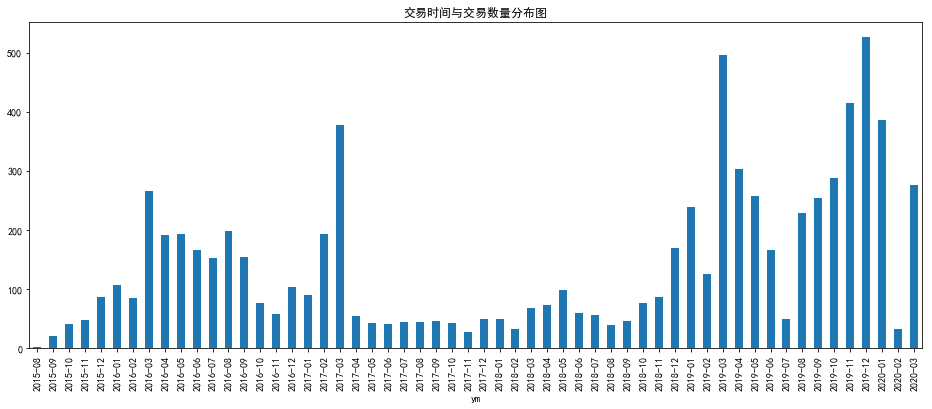

In [17]:
deal_time = deal_time.groupby('ym').count()['direction']
deal_time.plot(kind='bar',x=u'交易时间',y='数量',title=u'交易时间与交易数量分布图', figsize=(16,6))

链家网厦门市2015年6月到2020年3月的二手房交易数量为7866条，交易数量与交易时间的分布如上图所示。

#### 2.交易数量随月份的变化

In [18]:
#数据记录了2015-05年到2020-03之间的链家网二手房的交易数据，为了分析交易数量随月份的变化，删除了2015年5月到2016年3月的数据。
house_month = df_deal[~df_deal['ym'].str.contains('2015-05|2015-06|2015-07|2015-08|2015-09|2015-10|2015-11|2015-12|2016-01|2016-02|2016-03')]
house_month.shape

(7214, 19)

In [19]:
house_month = house_month.groupby('deal_month').count()['direction']
house_month

deal_month
1      763
2      381
3     1214
4      620
5      589
6      431
7      300
8      507
9      497
10     482
11     584
12     846
Name: direction, dtype: int64

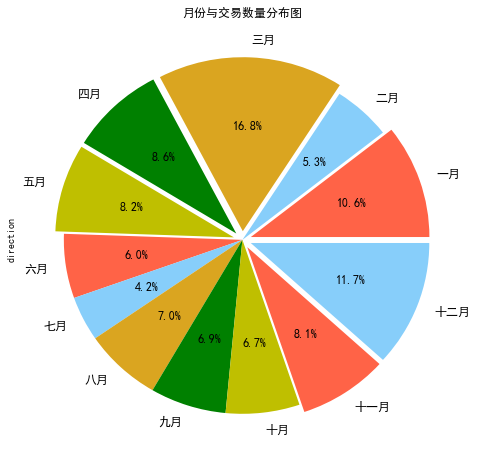

In [20]:
labels=['一月','二月','三月','四月','五月','六月','七月','八月','九月','十月','十一月','十二月']
explode=(0.05,0.0,0.05,0.05,0.05,0.0,0.0,0.0,0.0,0.0,0.05,0.05)
colors = ['tomato', 'lightskyblue', 'goldenrod', 'green', 'y','tomato', 'lightskyblue', 'goldenrod', 'green', 'y','tomato', 'lightskyblue']
title = u'月份与交易数量分布图'
plt.title(title,fontsize=20)
house_month.plot(kind='pie',labels=labels,title=title,autopct='%1.1f%%', figsize=(8,8),explode=explode, fontsize=12,colors=colors)

结论：分析了2016年4月到2020年3月链家网记录的7214条厦门二手房的交易记录，从户型与交易数量分布图可以看到一年有两个交易的高峰，3月到5月和11月到1月，此外三月是交易的最高峰，2016到2020年3月份的成交数量占记录总数的百分之16.8 ，数量为1214套。

#### 3.哪几种户型最受欢迎

In [21]:
#将type列中包含字段‘- -室- -厅’删除
df_type = df_deal[~df_deal['type'].str.contains('- -室- -厅')]
df_type.shape

(7856, 19)

In [22]:
house_type = df_type['type'].value_counts()
house_type.head(10)

2室2厅1厨1卫    1477
3室2厅1厨2卫    1382
2室1厅1厨1卫    1284
1室1厅1厨1卫     841
3室2厅1厨1卫     802
4室2厅1厨2卫     428
3室1厅1厨1卫     315
1室0厅1厨1卫     311
2室2厅1厨2卫     142
3室1厅1厨2卫     119
Name: type, dtype: int64

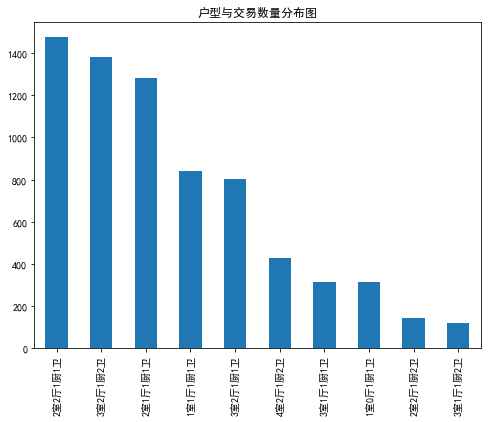

In [23]:
house_type.head(10).plot(kind='bar',x=u'户型',y=u'数量',title=u'户型与交易数量分布图', figsize=(8,6))

结论：根据链家网厦门市二手房2015年5月到2019年11月的7856条交易数据可知，成交量最多的前三名户型分别是：2室2厅1厨1卫、3室2厅1厨2卫、2室1厅1厨1卫。

#### 4.不同区域的房产均价

In [25]:
house_region = df_deal.groupby(['region']).mean()['unit_price/yuan']
house_region

region
同安    26190.451128
思明    46372.013909
海沧    29440.036829
湖里    40899.410356
翔安    24799.805471
集美    29478.907153
Name: unit_price/yuan, dtype: float64

In [26]:
df_deal.pivot_table(index='region',values=['unit_price/yuan'],aggfunc=[np.mean])

,mean
,unit_price/yuan
region,
同安,26190.451128
思明,46372.013909
海沧,29440.036829
湖里,40899.410356
翔安,24799.805471
集美,29478.907153


分析链家网厦门市二手房从2015年5月到2020年4月的7867条交易数据来看，岛内的房价远高于岛外的房价，岛内思明区的房价最高；岛外，海沧区和集美区的房价相差不大，高于同安区的房价，而同安区的房价又高于翔安区的房价。

#### 5.单位面积价格是否受到产权属性的影响

In [24]:
df_deal.pivot_table(index=['region','purpose'],values=['unit_price/yuan'],aggfunc=[np.mean])

mean
               unit_price/yuan
region purpose                
同安     别墅         22529.666667
       普通住宅       26274.930769
思明     别墅         51695.000000
       商业办公类      25384.200000
       普通住宅       46445.252417
海沧     别墅         40482.333333
       商业办公类      24658.428571
       平房         23112.000000
       普通住宅       29541.674556
湖里     别墅         55163.666667
       商业办公类      22592.627778
       普通住宅       43261.172921
翔安     别墅         32060.666667
       商业办公类      13053.500000
       普通住宅       25257.067308
集美     别墅         30878.666667
       商业办公类      20117.897436
       普通住宅       29727.148254

对于思明、湖里、集美、翔安、海沧，皆为别墅房价>普通住宅房价>商业办公类房价。